# Human Promoter Classification Naive Model

This notebook establishes baseline model for the long human promoter dataset. This will allow us to measure the impact of pretraining.

For more details on data processing and model architecture, see the [E. coli 1 Naive Model](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Bacteria/E.%20Coli/E.%20coli%201%20Naive%20Model.ipynb) notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/human/')

# Long Promoters

In [5]:
classification_df = pd.read_csv(path/'human_promoters_long.csv')

In [6]:
classification_df.head()

,Sequence,Target,set
0,GCTGGCCCGGTCTCCGCGGATCGGAGGCGAAGCCAGCCTGGCCCTC...,1,train
1,GAGGAGGAAGAGGGCGAGGCTTAGGGGGGCtccttggaggaggagg...,1,train
2,CCTTGCCCCCGAGTGCGCTGACTGTCTTGGCCGTCTAGGGGGCATG...,1,train
3,GGGAGGCGGTTCCCGGGGTTGGTGGGGGGAGCGGGAGGCGGTTCCC...,1,train
4,GGACCGGAGTGGGGACGGGCGGAGGAAGCCAAGAGGCTCGAGACCG...,1,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
train_df.shape, valid_df.shape, test_df.shape

((56834, 3), (6316, 3), (7017, 3))

In [9]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [10]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, test_df=test_df, tokenizer=tok, 
                                            text_cols='Sequence', label_cols='Target', bs=100)

In [13]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.4

In [14]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [15]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(1025, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(1025, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.16000000000000003)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e

In [16]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03


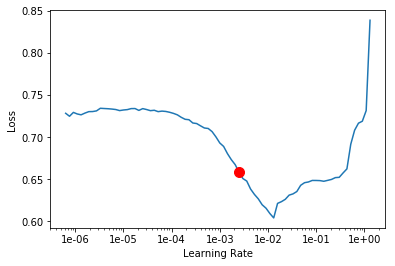

In [19]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(5, 2e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.338495,0.400679,0.832647
2,0.354243,0.448279,0.808898
3,0.349716,0.666679,0.600380
4,0.331410,0.382731,0.838347
5,0.324488,0.348949,0.845947


In [18]:
learn.fit_one_cycle(5, 1e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.321089,0.343537,0.846897
2,0.319117,0.348081,0.844839
3,0.316284,0.345304,0.849747
4,0.306629,0.342821,0.851172
5,0.318600,0.340820,0.850855


In [19]:
learn.save('hum_prom_long1')

# Test

In [20]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, 
                                            text_cols='Sequence', label_cols='Target', bs=100)
learn.data = data_clas

In [21]:
get_scores(learn)

Accuracy: 0.8583440216616788
False Positives: 0.045603534273906225
False Negatives: 0.09605244406441499
Recall: 0.7722972972972973
Precision: 0.8772064466615502
MCC: 0.7087446448721013
